In [1]:
import os

# ✅ Prevent XLA-related errors
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=0"

# ✅ Check if TensorFlow is installed correctly
try:
    import tensorflow as tf
    print(f"✅ TensorFlow version: {tf.__version__}")

    # ✅ Check if GPU is available
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        print(f"✅ GPU available: {physical_devices}")
    else:
        print("⚠️ No GPU detected. Running on CPU.")

except ImportError as e:
    print(f"❌ TensorFlow import failed: {e}")
    print("🛠️ Try installing it using: pip install tensorflow")

# ✅ Check CUDA and cuDNN versions
try:
    print("\n🔍 Checking CUDA and cuDNN versions...\n")
    os.system("nvcc --version")  # Show CUDA version
    os.system("nvidia-smi")  # Show GPU info and CUDA compatibility
except Exception as e:
    print(f"⚠️ Unable to check CUDA/cuDNN: {e}")

# ✅ Now safely import all other libraries
try:
    import numpy as np
    import scipy.io
    import cv2
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
    )
    from tensorflow.keras.optimizers import Adam
    import matplotlib.pyplot as plt

    print("\n✅ All libraries imported successfully!")

except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("🛠️ Install missing libraries using: pip install numpy scipy opencv-python matplotlib")



2025-02-22 19:31:37.750252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 19:31:37.750387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 19:31:37.887673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TensorFlow version: 2.15.0
✅ GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

🔍 Checking CUDA and cuDNN versions...

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
Sat Feb 22 19:31:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+===========

2025-02-22 19:31:47.730638: E external/local_tsl/tsl/util/command_line_flags.cc:103] Couldn't interpret value =0 for flag tf_xla_enable_xla_devices.



✅ All libraries imported successfully!


In [2]:
import numpy as np
import h5py
import os
import cv2

data_dir = "/kaggle/input/figshare-brain-tumor-dataset/dataset/data"
total_images = 3064  

X_tumor = []
Y_tumor_mask = []
tumour_labels = []  # Store labels in a list

for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    data = h5py.File(os.path.join(data_dir, filename), "r")

    # Extract tumor image
    image = np.array(data["cjdata"]["image"])
    image = cv2.resize(image, (128, 128))  # Resize for U-Net input
    image = image / 255.0  # Normalize pixel values
    X_tumor.append(image)

    # Extract tumor mask
    mask = np.array(data["cjdata"]["tumorMask"])  # Get segmentation mask
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (0 or 1)
    Y_tumor_mask.append(mask)

    # Extract tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
    label = int(np.array(data["cjdata"]["label"])[0][0])  # Ensure integer type
    tumour_labels.append(label)  # Append label to list

# Convert lists to numpy arrays
X_tumor = np.array(X_tumor).reshape(-1, 128, 128, 1)  # Add channel dimension
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 128, 128, 1)  # Segmentation masks
tumour_labels = np.array(tumour_labels)  # Convert to NumPy array

print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)  # (N, 128,128, 1)
print("Y_tumor_mask:", Y_tumor_mask.shape)  # (N, 128,128, 1)
print("Tumor Labels:", tumour_labels.shape)  # (N,)
print("Unique Labels:", np.unique(tumour_labels))  # Check unique labels


Dataset Shapes:
X_tumor: (3064, 128, 128, 1)
Y_tumor_mask: (3064, 128, 128, 1)
Tumor Labels: (3064,)
Unique Labels: [1 2 3]


In [3]:
import numpy as np
import os
import cv2

# Non-Tumor image extraction and labels
healthy_image_dir = "/kaggle/input/new-healthy/no_tumour/images"
healthy_mask_dir = "/kaggle/input/new-healthy/no_tumour/path_to_save_masks"

healthy_images = sorted(os.listdir(healthy_image_dir))
healthy_masks = sorted(os.listdir(healthy_mask_dir))

X_non_tumor = []
Y_non_tumor_mask = []
non_tumor_labels = []  # Assign label 4 for non-tumor images

for img_name, mask_name in zip(healthy_images, healthy_masks):
    # Load image
    img_path = os.path.join(healthy_image_dir, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    image = cv2.resize(image, (128, 128))
    image = image / 255.0  # Normalize
    X_non_tumor.append(image)

    # Load corresponding mask
    mask_path = os.path.join(healthy_mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure it's grayscale
    if mask is None:
        print(f"Error: Mask {mask_name} not loaded correctly!")
        continue
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 or 1)
    Y_non_tumor_mask.append(mask)

    # Assign label 4 for non-tumor images
    non_tumor_labels.append(4)

# Convert lists to numpy arrays
X_non_tumor = np.array(X_non_tumor).reshape(-1, 128, 128, 1)
Y_non_tumor_mask = np.array(Y_non_tumor_mask).reshape(-1, 128, 128, 1)
non_tumor_labels = np.array(non_tumor_labels )  # Convert to numpy array



print("Non-Tumor Dataset Shapes:")
print("X_non_tumor:", X_non_tumor.shape)  # (N, 128,128, 1)
print("Y_non_tumor_mask:", Y_non_tumor_mask.shape)  # (N, 128,128, 1)
print("Labels (Non-Tumor):", non_tumor_labels.shape)  # (N,)



Non-Tumor Dataset Shapes:
X_non_tumor: (2000, 128, 128, 1)
Y_non_tumor_mask: (2000, 128, 128, 1)
Labels (Non-Tumor): (2000,)


In [4]:
import numpy as np

# Combine all class labels into a single array
all_labels = np.concatenate((tumour_labels, non_tumor_labels ))

# Print unique labels and their counts
unique_labels, label_counts = np.unique(all_labels, return_counts=True)

# Map numeric labels to class names
class_mapping = {
    1: "Glioma",
    2: "Meningioma",
    3: "Pituitary",
    4: "Non-Tumor"
}

# Print results
print("Class Distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"{class_mapping[label]} (Label {label}): {count} samples")

Class Distribution:
Glioma (Label 1): 708 samples
Meningioma (Label 2): 1426 samples
Pituitary (Label 3): 930 samples
Non-Tumor (Label 4): 2000 samples


In [5]:

X_combined = np.concatenate((X_tumor, X_non_tumor), axis=0)
Y_combined_mask = np.concatenate((Y_tumor_mask, Y_non_tumor_mask), axis=0)

print("Final Combined Dataset Shapes:")
print("X_combined:", X_combined.shape)  # (Total_N, 128,128, 1)
print("Y_combined_mask:", Y_combined_mask.shape)  # (Total_N, 128,128, 1)


Final Combined Dataset Shapes:
X_combined: (5064, 128, 128, 1)
Y_combined_mask: (5064, 128, 128, 1)


In [6]:
# Ensure images are in float32 format and scaled to [0,1]
X_combined = X_combined.astype(np.float32)  # Convert to float32
Y_combined_mask = Y_combined_mask.astype(np.float32)  # Convert mask to float32

import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),  # Flip images horizontally
    A.VerticalFlip(p=0.5),  # Flip images vertically
    A.RandomRotate90(p=0.5),  # Rotate 90 degrees randomly
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),  
], additional_targets={'mask': 'mask'})  # Ensure mask is augmented the same way

# Store augmented images & masks
augmented_images, augmented_masks = [], []

# Apply augmentation
for img, mask in zip(X_combined, Y_combined_mask):
    augmented = augmentations(image=img, mask=mask)
    augmented_images.append(augmented["image"])
    augmented_masks.append(augmented["mask"])

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Merge original and augmented data
X_final = np.concatenate((X_combined, augmented_images), axis=0)
Y_final_mask = np.concatenate((Y_combined_mask, augmented_masks), axis=0)

#X_final = X_combined
#Y_final_mask =Y_combined_mask

# Print new dataset sizes
print(f"Final Dataset Shapes: {X_final.shape}, {Y_final_mask.shape}")


Final Dataset Shapes: (10128, 128, 128, 1), (10128, 128, 128, 1)


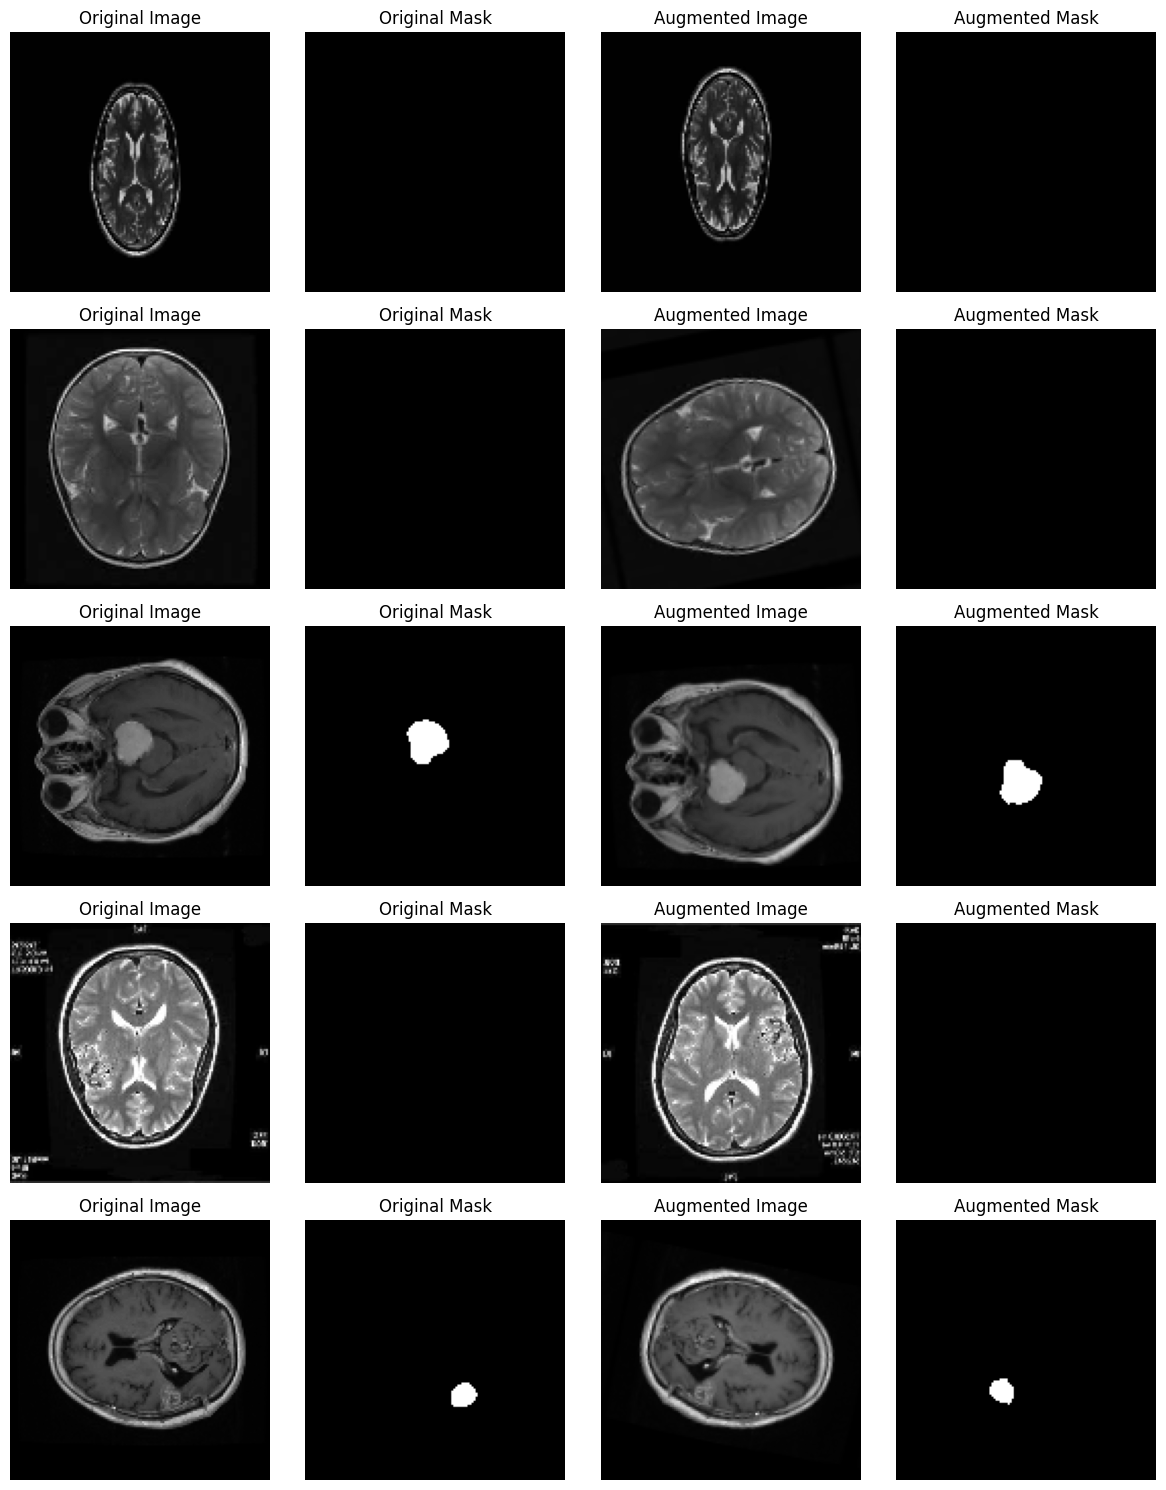

In [7]:
import matplotlib.pyplot as plt
import random

# Select random indices to visualize
num_samples = 5  # Number of samples to plot
indices = random.sample(range(len(X_combined)), num_samples)

# Plot images
fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples)) 

for i, idx in enumerate(indices):
    # Original Image & Mask
    original_img = X_combined[idx]
    original_mask = Y_combined_mask[idx]

    # Augmented Image & Mask
    augmented_img = augmented_images[idx]
    augmented_mask = augmented_masks[idx]

    # Display Original Image
    axes[i, 0].imshow(original_img, cmap="gray")  
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Display Original Mask
    axes[i, 1].imshow(original_mask, cmap="gray")  
    axes[i, 1].set_title("Original Mask")
    axes[i, 1].axis("off")

    # Display Augmented Image
    axes[i, 2].imshow(augmented_img, cmap="gray")  
    axes[i, 2].set_title("Augmented Image")
    axes[i, 2].axis("off")

    # Display Augmented Mask
    axes[i, 3].imshow(augmented_mask, cmap="gray")  
    axes[i, 3].set_title("Augmented Mask")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


In [21]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and temp (20%) [val+test]
X_train, X_temp, Y_train_mask, Y_temp_mask = train_test_split(
    X_final, Y_final_mask, test_size=0.3, random_state=42
)

# Split temp (50%) into validation (10%) and test (10%)
X_val, X_test, Y_val_mask, Y_test_mask = train_test_split(
    X_temp, Y_temp_mask, test_size=0.5, random_state=42
)

# Ensure the shapes are correct
print("Training Set:", X_train.shape, Y_train_mask.shape)
print("Validation Set:", X_val.shape, Y_val_mask.shape)
print("Test Set:", X_test.shape, Y_test_mask.shape)


Training Set: (7089, 128, 128, 1) (7089, 128, 128, 1)
Validation Set: (1519, 128, 128, 1) (1519, 128, 128, 1)
Test Set: (1520, 128, 128, 1) (1520, 128, 128, 1)


In [22]:
import numpy as np

# Expand grayscale images to RGB (Assuming X_train, X_val, X_test are grayscale)
X_train_rgb = np.stack([X_train] * 3, axis=-1)
X_val_rgb = np.stack([X_val] * 3, axis=-1)
X_test_rgb = np.stack([X_test] * 3, axis=-1)

# Expand grayscale masks to RGB (Assuming Y_train_mask, Y_val_mask, Y_test_mask are grayscale)
Y_train_mask_rgb = np.stack([Y_train_mask] * 3, axis=-1)
Y_val_mask_rgb = np.stack([Y_val_mask] * 3, axis=-1)
Y_test_mask_rgb = np.stack([Y_test_mask] * 3, axis=-1)

# Remove extra dimensions if present (this can prevent the shape (None, 128, 128, 1, 3))
X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_val_rgb = np.squeeze(X_val_rgb, axis=-2)
X_test_rgb = np.squeeze(X_test_rgb, axis=-2)

Y_train_mask_rgb = np.squeeze(Y_train_mask_rgb, axis=-2)
Y_val_mask_rgb = np.squeeze(Y_val_mask_rgb, axis=-2)
Y_test_mask_rgb = np.squeeze(Y_test_mask_rgb, axis=-2)

# Print new dataset sizes
print("Training Set (RGB):", X_train_rgb.shape, Y_train_mask_rgb.shape)
print("Validation Set (RGB):", X_val_rgb.shape, Y_val_mask_rgb.shape)
print("Test Set (RGB):", X_test_rgb.shape, Y_test_mask_rgb.shape)


Training Set (RGB): (7089, 128, 128, 3) (7089, 128, 128, 3)
Validation Set (RGB): (1519, 128, 128, 3) (1519, 128, 128, 3)
Test Set (RGB): (1520, 128, 128, 3) (1520, 128, 128, 3)


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, UpSampling2D, Concatenate, Input, Dropout, 
                                     Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Convolution Block
def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Decoder Block with better upsampling and skip connection handling
def decoder_block(input_tensor, skip_tensor, filters):
    x = UpSampling2D((2, 2), interpolation="bilinear")(input_tensor)
    x = Conv2D(filters, (3, 3), padding="same")(x)  # Extra convolution for stability
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Ensure skip tensor and upsampled tensor match in shape
    if x.shape[1] != skip_tensor.shape[1] or x.shape[2] != skip_tensor.shape[2]:
        skip_tensor = UpSampling2D((2, 2), interpolation="bilinear")(skip_tensor)

    x = Concatenate()([x, skip_tensor])
    x = conv_block(x, filters)
    x = Dropout(0.3)(x)  # Reduce overfitting
    return x

# Build EfficientNet U-Net Model
def build_efficientnet_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Load EfficientNetB0 as feature extractor
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder feature maps (skip connections)
    s1 = base_model.get_layer("block2a_expand_activation").output  # 64 filters
    s2 = base_model.get_layer("block3a_expand_activation").output  # 128 filters
    s3 = base_model.get_layer("block4a_expand_activation").output  # 256 filters
    b1 = base_model.get_layer("block6a_expand_activation").output  # Bottleneck (512 filters)

    # Decoder path
    d1 = decoder_block(b1, s3, 512)  # 512 filters
    d2 = decoder_block(d1, s2, 256)  # 256 filters
    d3 = decoder_block(d2, s1, 128)  # 128 filters

    # Final upsampling & segmentation head
    d4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(d3)
    d4 = conv_block(d4, 64)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  # Final segmentation map

    # Model definition
    model = Model(inputs, outputs, name="EfficientNet_U-Net_Optimized")

    return model

# Build the model
model = build_efficientnet_unet()

# Print model summary
model.summary()


Model: "EfficientNet_U-Net_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 128, 128,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 128, 128,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 10,281,928 (39.22 MB)

 Trainable params: 10,260,705 (39.14 MB)

 Non-trainable params: 21,223 (82.91 KB)

In [26]:
def postprocess_mask(mask, threshold=0.5, kernel_size=5):
    mask = tf.cast(mask > threshold, tf.float32)
    kernel = tf.ones((kernel_size, kernel_size), dtype=tf.float32)

    # Perform dilation
    mask = tf.nn.dilation2d(mask, kernel, strides=[1, 1, 1, 1], padding="SAME")

    # Perform closing: dilation followed by erosion
    mask = tf.nn.erosion2d(mask, kernel, strides=[1, 1, 1, 1], padding="SAME")
    mask = tf.nn.dilation2d(mask, kernel, strides=[1, 1, 1, 1], padding="SAME")
    
    return mask


In [27]:
import tensorflow as tf

def iou_metric(y_true, y_pred):
    """
    Computes IoU without post-processing.
    """
    # Ensure true and predicted masks are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # Sum over height, width, and channels
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    # Compute IoU and handle numerical stability
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Average IoU over the batch
    return tf.reduce_mean(iou)


In [29]:
import tensorflow as tf

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    """
    Improved Tversky Loss for imbalanced segmentation.
    """
    smooth = tf.keras.backend.epsilon()
    
    # Convert to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, smooth, 1.0 - smooth)  # Avoid log(0)

    # Compute Tversky components
    tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])  
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])  

    # Tversky index
    tversky_index = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    
    return tf.reduce_mean(1 - tversky_index)  

def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=1.3):
    """
    Optimized Focal Tversky Loss with Log-Cosh.
    """
    tversky = tversky_loss(y_true, y_pred, alpha, beta)
    
    # Use log-cosh instead of tf.pow for better gradient stability
    focal_tversky = tf.math.log(tf.math.cosh(tversky * gamma))
    
    return focal_tversky  

def combined_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=1.3, weight=0.5):
    """
    Hybrid loss: Focal Tversky Loss + Dice Loss.
    - Dice Loss helps improve small region segmentation.
    """
    dice = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1e-6) / \
           (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)
    
    tversky = focal_tversky_loss(y_true, y_pred, alpha, beta, gamma)
    
    return weight * dice + (1 - weight) * tversky  # Balance both losses


In [30]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,  # Use the defined optimizer
    loss=combined_loss,  
    metrics=[iou_metric, tf.keras.metrics.BinaryAccuracy(name="accuracy")]
)


In [31]:
# Train the model with the 3-channel mask
history = model.fit(
    X_train, Y_train_mask,
    validation_data=(X_val, Y_val_mask),
    batch_size=16,
    epochs=20
)

Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 173s 209ms/step - accuracy: 0.9026 - iou_metric: 0.0688 - loss: 0.6873 - val_accuracy: 0.9819 - val_iou_metric: 0.0870 - val_loss: 0.6553
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.9912 - iou_metric: 0.2046 - loss: 0.4472 - val_accuracy: 0.9930 - val_iou_metric: 0.2588 - val_loss: 0.3658
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.9940 - iou_metric: 0.2967 - loss: 0.3214 - val_accuracy: 0.9945 - val_iou_metric: 0.3107 - val_loss: 0.2894
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.9952 - iou_metric: 0.3457 - loss: 0.2617 - val_accuracy: 0.9953 - val_iou_metric: 0.3514 - val_loss: 0.2553
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.9958 - iou_metric: 0.3772 - loss: 0.2313 - val_accuracy: 0.9956 - val_iou_metric: 0.3532 - val_loss: 0.2478
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.9961 - iou_metric: 0.4001 - loss: 0.2106 - val_acc

In [37]:
# Save model in .h5 format
model.save("/kaggle/working/my_segmentation_model_100_efficientnet.h5")  # Saves as a folder

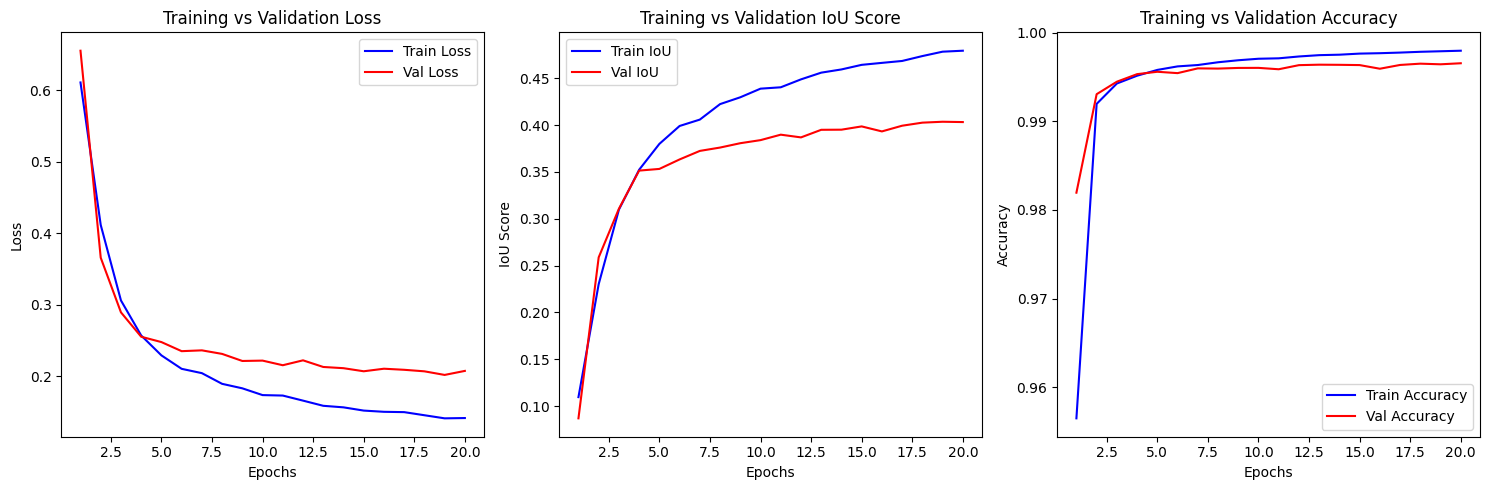

In [32]:
import matplotlib.pyplot as plt

# Extract metrics from history
epochs = range(1, len(history.history["loss"]) + 1)

# Plot Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history["loss"], label="Train Loss", color="blue")
plt.plot(epochs, history.history["val_loss"], label="Val Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot IoU Metric
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history["iou_metric"], label="Train IoU", color="blue")
plt.plot(epochs, history.history["val_iou_metric"], label="Val IoU", color="red")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("Training vs Validation IoU Score")
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy", color="blue")
plt.plot(epochs, history.history["val_accuracy"], label="Val Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import scipy.ndimage

def postprocess_mask(mask, threshold=0.5, kernel_size=3):
    """
    Apply thresholding and morphological operations (dilation followed by erosion) for post-processing.
    """
    # Apply thresholding to create a binary mask
    mask = mask > threshold

    # Ensure the mask is 2D (height, width)
    if len(mask.shape) > 2:
        mask = mask.squeeze()  # Remove any extra dimensions (e.g., channel dimension)

    # Define a kernel for dilation and erosion (3x3 kernel)
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

    # Perform dilation (expand the mask)
    mask = scipy.ndimage.binary_dilation(mask, structure=kernel)
    
    # Perform erosion (shrink the mask)
    mask = scipy.ndimage.binary_erosion(mask, structure=kernel)
    
    return mask.astype(np.float32)

# Evaluate the model
test_loss, test_accuracy, *other_metrics = model.evaluate(X_test, Y_test_mask, verbose=1)

# Get predictions
predictions = model.predict(X_test, verbose=1)

# Convert predictions and ground truth to binary masks
threshold = 0.15
binary_predictions = (predictions > threshold).astype(np.uint8)
binary_y_test = (Y_test_mask > threshold).astype(np.uint8)

# Apply post-processing to the predictions
processed_predictions = []
for i in range(binary_predictions.shape[0]):
    processed_mask = postprocess_mask(binary_predictions[i], threshold=threshold)
    processed_predictions.append(processed_mask)

# Stack the processed predictions
processed_predictions = np.stack(processed_predictions)

# Flatten the arrays to match the expected shape for MeanIoU
binary_y_test_flat = binary_y_test.reshape(-1)
processed_predictions_flat = processed_predictions.reshape(-1)

# Compute Mean IoU
num_classes = 2  # Background (0) and Tumor (1)
iou_metric = MeanIoU(num_classes=num_classes)

# Update IoU metric with post-processed predictions and ground truth
iou_metric.update_state(binary_y_test_flat, processed_predictions_flat)

# Get IoU score
test_iou = iou_metric.result().numpy()
print(f"Test IoU Score: {test_iou:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9968 - iou_metric: 0.4118 - loss: 0.2010
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Test IoU Score: 0.8543


In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU, Accuracy

# Dice Score Function
def dice_score(y_true, y_pred, threshold=0.5):
    """
    Computes the Dice Similarity Coefficient (DSC).
    """
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    y_true_bin = (y_true > threshold).astype(np.uint8)

    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)

    return (2 * intersection + 1e-6) / (union + 1e-6)

# Pixel Accuracy Function
def pixel_accuracy(y_true, y_pred, threshold=0.5):
    """
    Computes pixel accuracy.
    """
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    y_true_bin = (y_true > threshold).astype(np.uint8)

    correct_pixels = np.sum(y_true_bin == y_pred_bin)
    total_pixels = np.prod(y_true_bin.shape)

    return correct_pixels / total_pixels

# Average IoU Calculation (your original function)
def calculate_average_iou(y_true, y_pred, threshold=0.5):
    """
    Computes the average IoU score across the test dataset.
    """
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    y_true_bin = (y_true > threshold).astype(np.uint8)

    # Compute IoU for each sample
    iou_scores = []
    for i in range(len(y_true_bin)):
        intersection = np.logical_and(y_true_bin[i], y_pred_bin[i]).sum()
        union = np.logical_or(y_true_bin[i], y_pred_bin[i]).sum()
        iou = (intersection + 1e-6) / (union + 1e-6)  # Adding smooth factor to avoid division by zero
        iou_scores.append(iou)

    # Compute the average IoU
    avg_iou = np.mean(iou_scores)
    return avg_iou

# Evaluate the model
test_loss, test_accuracy, *other_metrics = model.evaluate(X_test, Y_test_mask, verbose=1)

# Get predictions
predictions = model.predict(X_test, verbose=1)

# Compute Dice Score
dice = dice_score(Y_test_mask, predictions)
print(f"Dice Score: {dice:.4f}")

# Compute Pixel Accuracy
pixel_acc = pixel_accuracy(Y_test_mask, predictions)
print(f"Pixel Accuracy: {pixel_acc:.4f}")

# Compute Average IoU
average_iou = calculate_average_iou(Y_test_mask, predictions)
print(f"Average IoU Score: {average_iou:.4f}")

# Test Accuracy
test_acc = test_accuracy  # This is directly from model.evaluate()
print(f"Test Accuracy: {test_acc:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9968 - iou_metric: 0.4118 - loss: 0.2010
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Dice Score: 0.8319
Pixel Accuracy: 0.9967
Average IoU Score: 0.8015
Test Accuracy: 0.9967


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


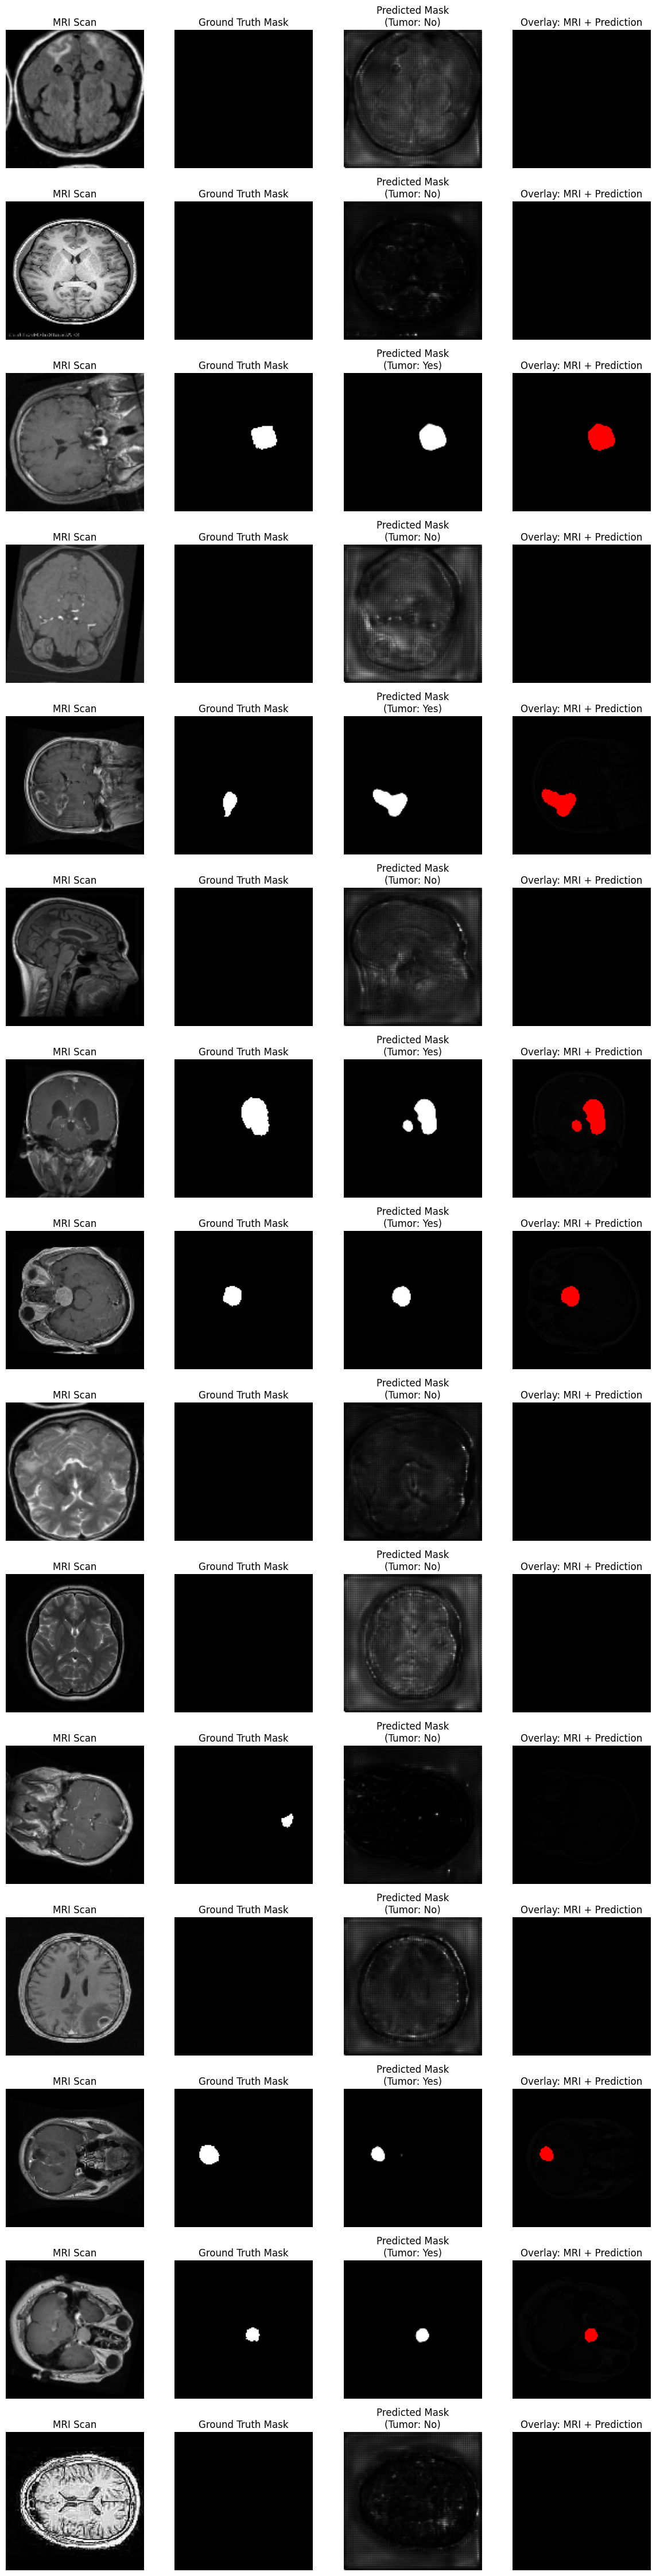

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def classify_tumor(y_pred, y_true, threshold=0.5, min_tumor_size=20):
    """
    Determines if a tumor is present based on both the predicted mask and the ground truth mask.
    If the predicted mask has any tumor pixels in the area where ground truth has tumor pixels, it's a tumor.
    """
    binary_pred_mask = (y_pred > threshold).astype(np.uint8)
    binary_true_mask = (y_true > threshold).astype(np.uint8)

    # Count the number of white pixels in the predicted mask
    predicted_tumor_pixels = np.sum(binary_pred_mask)
    
    # Count the number of white pixels in the ground truth mask (actual tumor area)
    ground_truth_tumor_pixels = np.sum(binary_true_mask)

    # If there are predicted tumor pixels, check for overlap with ground truth
    if predicted_tumor_pixels > min_tumor_size and ground_truth_tumor_pixels > 0:
        return "Yes"
    else:
        return "No"

def visualize_predictions(X_test, Y_test_mask, predictions, num_samples=5, threshold=0.5):
    """
    Plots original MRI, ground truth mask, predicted mask, and overlay with classification result.
    """
    num_samples = min(num_samples, len(X_test))  # Ensure valid sample count
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples))

    for i in range(num_samples):
        original_image = np.squeeze(X_test[i])  # Remove channel dimension if needed
        true_mask = np.squeeze(Y_test_mask[i])
        predicted_mask = np.squeeze(predictions[i])

        # Convert predicted mask to binary
        predicted_mask_bin = (predicted_mask > threshold).astype(np.uint8)
        
        # Classify tumor presence based on pixel count and overlap with ground truth
        tumor_presence = classify_tumor(predicted_mask, true_mask)

        # Create overlay image
        overlay = np.stack([original_image] * 3, axis=-1)  # Convert grayscale to RGB
        overlay[predicted_mask_bin == 1] = [255, 0, 0]  # Highlight prediction in Red

        # Plot images
        ax = axes[i] if num_samples > 1 else axes  # Handle single-row case
        ax[0].imshow(original_image, cmap="gray")
        ax[0].set_title("MRI Scan")
        ax[0].axis("off")

        ax[1].imshow(true_mask, cmap="gray")
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis("off")

        ax[2].imshow(predicted_mask, cmap="gray")
        ax[2].set_title(f"Predicted Mask\n(Tumor: {tumor_presence})")
        ax[2].axis("off")

        ax[3].imshow(overlay.astype(np.uint8))
        ax[3].set_title("Overlay: MRI + Prediction")
        ax[3].axis("off")

    plt.tight_layout()
    plt.show()

# Generate predictions
predictions = model.predict(X_test)

# Visualize results for 5 samples
visualize_predictions(X_test, Y_test_mask, predictions, num_samples=15)


In [20]:
# Predict Tumor Segmentation using the U-Net model
predicted_masks = model.predict(X_test)  # Assuming X_test contains MRI images

# Convert predictions to binary masks (thresholding)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


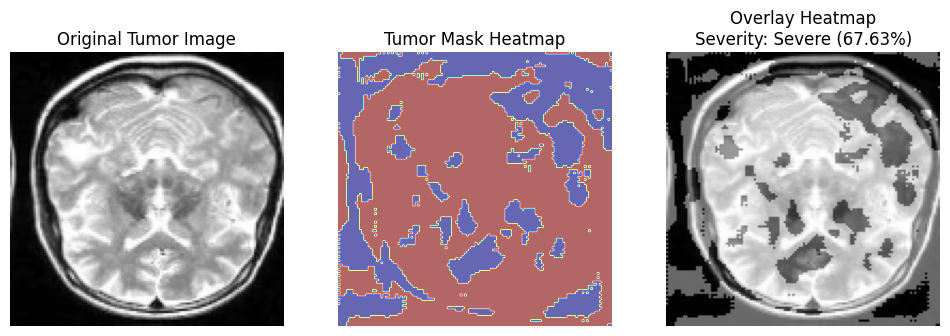

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def compute_tumor_size(mask):
    return np.sum(mask)  # Count tumor pixels in the mask

# Compute tumor sizes for the entire batch
tumor_sizes = [compute_tumor_size(mask) for mask in binary_predictions]

# Normalize by image size (assuming 128x128 images)
tumor_percentages = [(size / (128 * 128)) * 100 for size in tumor_sizes]

# Compute severity thresholds based on percentiles
mild_threshold = np.percentile(tumor_percentages, 33)
moderate_threshold = np.percentile(tumor_percentages, 66)

def classify_tumor_severity(tumor_percentage):
    if tumor_percentage <= mild_threshold:
        return "Mild"
    elif tumor_percentage <= moderate_threshold:
        return "Moderate"
    else:
        return "Severe"

# Assign severity labels to each sample
tumor_severity_labels = [classify_tumor_severity(p) for p in tumor_percentages]

# Select a sample index for visualization (change this to display different samples)
sample_idx = 99

# Extract the image and mask for the selected sample
tumor_image = X_test[sample_idx].squeeze()  # Grayscale MRI image
tumor_mask = binary_predictions[sample_idx].squeeze()  # Segmented binary mask

# Compute tumor size and percentage for selected image
tumor_size = np.sum(tumor_mask)
tumor_percentage = (tumor_size / (128 * 128)) * 100
severity_label = classify_tumor_severity(tumor_percentage)

# Choose colormap based on severity level
colormap_dict = {
    "Mild": cv2.COLORMAP_COOL,
    "Moderate": cv2.COLORMAP_JET,
    "Severe": cv2.COLORMAP_HOT
}
selected_colormap = colormap_dict[severity_label]

# Convert Tumor Mask to Heatmap
heatmap = cv2.applyColorMap((tumor_mask * 255).astype(np.uint8), selected_colormap)

# Convert Tumor Image to uint8 for overlay
tumor_image_uint8 = (tumor_image * 255).astype(np.uint8)
tumor_image_bgr = cv2.cvtColor(tumor_image_uint8, cv2.COLOR_GRAY2BGR)

# Overlay Heatmap on Original Image
overlay = cv2.addWeighted(tumor_image_bgr, 0.6, heatmap, 0.4, 0)

# Plot the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(tumor_image, cmap="gray")
plt.title("Original Tumor Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(tumor_mask, cmap="jet", alpha=0.6)
plt.title("Tumor Mask Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay Heatmap\nSeverity: {severity_label} ({tumor_percentage:.2f}%)")
plt.axis("off")

plt.show()


In [48]:
import numpy as np

def compute_tumor_size(mask):
    return np.sum(mask)  # Count tumor pixels in the mask

tumor_sizes = [compute_tumor_size(mask) for mask in predicted_masks_binary]

# Normalize by image size (assuming 128x128 images)
tumor_percentages = [(size / (128 * 128)) * 100 for size in tumor_sizes]

# Find severity thresholds using percentiles (33% and 66%)
mild_threshold = np.percentile(tumor_percentages, 33)
moderate_threshold = np.percentile(tumor_percentages, 66)

def classify_tumor_severity(tumor_percentage):
    if tumor_percentage <= mild_threshold:
        return "Mild"
    elif tumor_percentage <= moderate_threshold:
        return "Moderate"
    else:
        return "Severe"

# Assign severity labels
tumor_severity_labels = [classify_tumor_severity(p) for p in tumor_percentages]

# Print severity distribution
unique, counts = np.unique(tumor_severity_labels, return_counts=True)
severity_distribution = dict(zip(unique, counts))

print("Tumor Severity Distribution:", severity_distribution)


Tumor Severity Distribution: {'Mild': 251, 'Moderate': 250, 'Severe': 259}


In [49]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compute_tumor_size(mask):
    return np.sum(mask)  # Count tumor pixels in the mask

# Compute tumor sizes
tumor_sizes = [compute_tumor_size(mask) for mask in predicted_masks_binary]

# Normalize by image size (assuming 128x128 images)
tumor_percentages = [(size / (128 * 128)) * 100 for size in tumor_sizes]

# Compute severity thresholds
mild_threshold = np.percentile(tumor_percentages, 33)
moderate_threshold = np.percentile(tumor_percentages, 66)

def classify_tumor_severity(tumor_percentage):
    if tumor_percentage <= mild_threshold:
        return "Mild"
    elif tumor_percentage <= moderate_threshold:
        return "Moderate"
    else:
        return "Severe"

# Assign severity labels
tumor_severity_labels = [classify_tumor_severity(p) for p in tumor_percentages]

# Select a sample index for visualization
sample_idx = 99  # Change this for different samples

# Extract the image and mask
tumor_image = X_test[sample_idx].squeeze()  # Grayscale MRI image
tumor_mask = predictions_bin[sample_idx].squeeze()  # Segmented mask

# Compute severity for the selected image
tumor_size = np.sum(tumor_mask)
tumor_percentage = (tumor_size / (128 * 128)) * 100
severity_label = classify_tumor_severity(tumor_percentage)

# Choose color map based on severity
colormap_dict = {
    "Mild": cv2.COLORMAP_COOL,
    "Moderate": cv2.COLORMAP_JET,
    "Severe": cv2.COLORMAP_HOT
}
selected_colormap = colormap_dict[severity_label]

# Convert Tumor Mask to a Heatmap
heatmap = cv2.applyColorMap((tumor_mask * 255).astype(np.uint8), selected_colormap)

# Convert Tumor Image to uint8 for overlay
tumor_image_uint8 = (tumor_image * 255).astype(np.uint8)
tumor_image_bgr = cv2.cvtColor(tumor_image_uint8, cv2.COLOR_GRAY2BGR)

# Overlay Heatmap on Original Image
overlay = cv2.addWeighted(tumor_image_bgr, 0.6, heatmap, 0.4, 0)

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(tumor_image, cmap="gray")
plt.title("Original Tumor Image")
plt.axis("off")

plt.subplot(1, 3, 2)
sns.heatmap(tumor_mask, cmap="jet", alpha=0.6)
plt.title("Tumor Mask Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay Heatmap\nSeverity: {severity_label} ({tumor_percentage:.2f}%)")
plt.axis("off")

plt.show()


NameError: name 'predictions_bin' is not defined

In [ ]:
'''import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute the Dice Coefficient.
    Args:
        y_true: Ground truth labels, shape (batch_size, height, width, 1).
        y_pred: Predicted labels, shape (batch_size, height, width, 1).
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice Coefficient.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)


def dice_coefficient(y_true, y_pred):
    """
    Compute Dice Coefficient for segmentation evaluation.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    smooth = 1e-6  # To avoid division by zero

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return (2. * intersection + smooth) / (union + smooth)
def dice_bce_loss(y_true, y_pred, bce_weight=0.5, dice_weight=0.5):
    """
    Compute the combined Dice + Binary Cross-Entropy Loss.
    Args:
        y_true: Ground truth labels, shape (batch_size, height, width, 1).
        y_pred: Predicted labels, shape (batch_size, height, width, 1).
        bce_weight: Weight for the BCE loss component.
        dice_weight: Weight for the Dice loss component.
    Returns:
        Combined Dice + BCE Loss.
    """
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)  # ✅ FIXED: Removed extra argument

    combined_loss = (bce_weight * bce_loss) + (dice_weight * dice_loss)
    return combined_loss'''
